# Импорт модулей


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import tensorflow.keras.backend as K
import pandas as pd

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout


# Создадим список в который добавим все пути к картинкам для разных рамок

In [3]:
path = '/content/drive/MyDrive/Crops/600img'

image_path = []
for dir in os.listdir(path):
  for file_name in os.listdir('{}/{}'.format(path, dir)):
    image_path.append('{}/{}/{}'.format(path, dir, file_name))

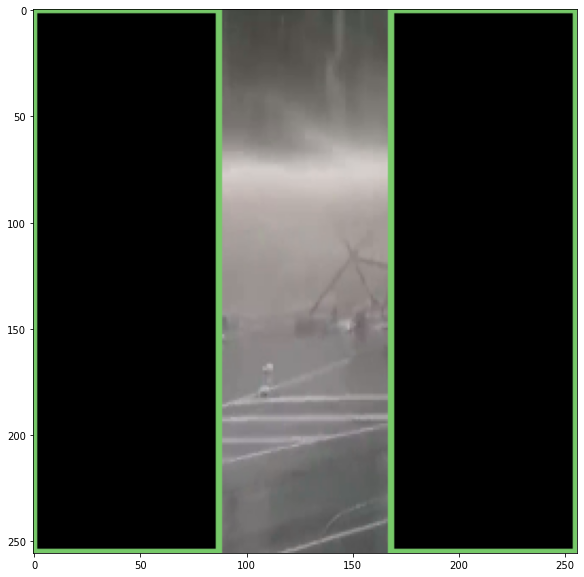

In [11]:
def label_(path):
  """
  Функция принимает на вход путь к картинке и исходя из названия возвращает 
  width, point1 для картинки target
  """
  if path.split('/')[-2][-3] == '1':
    width, point1  =  87, 168
  elif path.split('/')[-2][-3] == '7':
    width, point1  =  56, 200
  elif path.split('/')[-2][-3] == '3':
    width, point1  =  24, 232
  elif path.split('/')[-2][-3] == '0':
    width, point1  =  1, 1
  return width, point1

def create_examle(path):
  """ 
  Функция принимает на вход путь к файлу с картинкой.
  Меняет размеры картинки на (256, 256, 3)
  Получает от функции label_ width и point1
  Возращает картинку, ширину рамки и координату для верхнего левого угла второй рамки
  """
  image = cv2.imread(path)
  image = cv2.resize(image, (256, 256))
  width, point1  =  label_(path)
  return image, width, point1

def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
  """
  Функция для рисования квадратных рамок
  Для моей разметки функция рисует зеленую рамку,
  для разметки модели функция рисует красную рамку.

  Если предсказанные значения не передаются в функцию то будут рисоваться только 
  зеленый рамки
  """
  image = image.copy()
  color = (119, 201, 105)
  
  width, point1 = gt_coords
  width, point1 = int(width), int(point1)

  if  width != 1 and point1 != 1:
    cv2.rectangle(image, (0, 0), (width, 255), color, thickness=2)
    cv2.rectangle(image, (point1, 0), (point1 + width, 255), color, thickness=2)

  if len(pred_coords) != 0: 

    if 0.7 < width < 1.3 and 0.7 < point1 < 1.3:
      return image.astype('uint8')
      
    color = (245, 2, 2)   
    width, point1 = pred_coords
    width, point1 = int(width), int(point1)

    cv2.rectangle(image, (0, 0), (width, 255), color, thickness=2)
    cv2.rectangle(image, (point1, 0), (point1 + width, 255), color, thickness=2)

  return image.astype('uint8')

# Пример рамок на картинке 
image = cv2.imread('{}/G32V11H0/QoGJkZCoLr8-G32V11H0-00574-32.96s-crop.jpeg'.format(path))
image = cv2.resize(image, (256, 256))

fig, axes = plt.subplots(figsize=(16, 10))
plt.imshow(plot_bounding_box(image, gt_coords=[87, 168]))
plt.show()

# Генератор партий (batch)
НА вход генератора подается список путей к картинкам и размер партии (по умолчанию 16). С помощью метода np.random.choice получаем рандомный список путей до картинок (filenames), размером 16 (batch_size). Создаем два массива numpy заполненых нулями.

В цикле для каждого элемента из списка filenames получаем фотографию (image, type(np.array)), ширину (width) первого прямоугольника (box), координату х (point1) для верхнего левого угла второго прямоугольника (box)

Заменяем в массиве x_batch нули, для каждой картинки, нормированной картинкой.
Заменяем в массиве bbox_batch нули, массивом из width и point1

С помощью команды yield будем возращать словарь каждый раз когда запрашивают генератор. В словаре передаем партию из images и партию width и point1

In [5]:
def data_generator(path, batch_size=16):
  while True:

    filenames = np.random.choice(path, batch_size)

    x_batch = np.zeros((batch_size, 256, 256, 3))
    bbox_batch = np.zeros((batch_size, 2))
  
    for i, k in enumerate(filenames):
      image, width, point1 = create_examle(k)
      x_batch[i] = image / 255.
      bbox_batch[i] = np.array([width, point1])
    yield {'image': x_batch}, {'box_out': bbox_batch}

for i, j in data_generator(image_path):
  break

# Метрика качества IoU

Функция принимает на вход фактически значения и предсказанные
Вычисляется площадь пересечения фактического и предсказанного прямоугольников,
вычисляется суммарная площадь фактического и предсказанного прямоугольников.
IoU вычисляется как площадь пересечения деленная на суммарную площадь.
Так как рамки две с левого и правого края то усредняем IoU для лейвой и правой рамки.
Выходом функции является усредненное IoU для партии изображений.

In [6]:
def iou(y_true, y_pred):
    y_true = np.array(y_true).astype(np.float32)
    y_pred = np.array(y_pred).astype(np.float32)

    mean_img_iou = []
    for y_t, y_p in zip(y_true, y_pred):
      
      width_true , point1_true = y_t[0], y_t[1]
      width_pred , point1_pred = y_p[0], y_p[1]

      x_max_box2 = max(point1_true, point1_pred)
      x_min_box2 = min(point1_true + width_true, point1_pred + width_pred)
      width_box1 = min(width_true, width_pred)
      
      width_box2 = x_min_box2 - x_max_box2

      area_of_intersection_of_two_boxes_box1 = width_box1 * 255
      area_of_intersection_of_two_boxes_box2 = width_box2 * 255

      square_true_box1 = 255 * width_true
      square_pred_box1 = 255 * width_pred

      square_true_box2 = 255 * (point1_true + width_true - point1_true)
      square_pred_box2 = 255 * (point1_pred + width_pred - point1_pred)

      area_of_union_of_two_boxes_box1 = square_true_box1 + square_pred_box1 - area_of_intersection_of_two_boxes_box1
      area_of_union_of_two_boxes_box2 = square_true_box2 + square_pred_box2 - area_of_intersection_of_two_boxes_box2

      iou_box1 = area_of_intersection_of_two_boxes_box1 / area_of_union_of_two_boxes_box1
      iou_box2 = area_of_intersection_of_two_boxes_box2 / area_of_union_of_two_boxes_box2

      mean_img_iou.append((iou_box1 + iou_box2) / 2)

    return sum(mean_img_iou) / len(mean_img_iou)




# Архитектура модели

Первый слой входной, передаем в него размер картинок и название слоя image.

Далее с помощью цикла будем задавать слои свертки (Conv2D), пулинга (MaxPool2D), и нормализации (BatchNormalization), а так же генерировать разное количество фильтров свертки (n_filters) для сверточных слоев.
В сверточный слой передаем количество фильтров (n_filters), сверточный фильтр будет размером 3 на 3, активацией будет выступать функция relu
После проходжения свертки получившиеся значения нормируем BatchNormalization.
С помощью слоя MaxPool2D уменьшаем размеры получившихся тензоров 
Слой Flatten нужен, бы выход последнего слоя пулинга превратить в массив с одним измерением.
Полносвязный слой (Dense) в нем 256 нейронов и активация relu
Последний полносвязный слой, в котором 2 нейрона так же как количество прогнозируемых переменных  width, point1

Командой tf.keras.models.Model(input_, box_out) создаем модель, а с помощью команды model.summary() выводим архитектуру получившийся подели и  например характеристики сколько обучаемы и не обучаемых элементов.

Командой model.compile компилируем получившуюся модель. Функцией потерь будет среднеквадротичная функция mse, оптимизатором модели будет Adam (tf.keras.optimizers.Adam(learning_rate=1e-3)), метрикой качества модели будет IoU (    metrics=[mean_pred].
Аргумент run_eagerly=True нужен, что бы метрика качества работала

In [7]:
input_ = Input(shape=(256, 256, 3), name='image')

x = input_

for i in range(0, 5):
  n_filters = 2**(4 + i)
  x = Conv2D(n_filters, 3, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, box_out)
model.summary()

model.compile(
    loss='mse', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[iou], run_eagerly=True
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 32)     128   

# Обучаем модель
Первым аргументом передаем генератор партий, количество эпох 30

In [8]:
history = model.fit(data_generator(image_path),
              epochs = 30,
              steps_per_epoch = 500)

Epoch 1/30
500/500 [==============================] - 1893s 4s/step - loss: 584.5949 - iou: 0.4680
Epoch 2/30
500/500 [==============================] - 1039s 2s/step - loss: 21.4427 - iou: 0.7230
Epoch 3/30
500/500 [==============================] - 584s 1s/step - loss: 12.9504 - iou: 0.7789
Epoch 4/30
500/500 [==============================] - 389s 776ms/step - loss: 11.2752 - iou: 0.7953
Epoch 5/30
500/500 [==============================] - 277s 554ms/step - loss: 8.4250 - iou: 0.8168
Epoch 6/30
500/500 [==============================] - 216s 432ms/step - loss: 8.5490 - iou: 0.8192
Epoch 7/30
500/500 [==============================] - 178s 356ms/step - loss: 7.8460 - iou: 0.8324
Epoch 8/30
500/500 [==============================] - 157s 315ms/step - loss: 8.8479 - iou: 0.8362
Epoch 9/30
500/500 [==============================] - 150s 299ms/step - loss: 5.8286 - iou: 0.8630
Epoch 10/30
500/500 [==============================] - 147s 294ms/step - loss: 5.5955 - iou: 0.8636
Epoch 11/30

# Тестируем модель

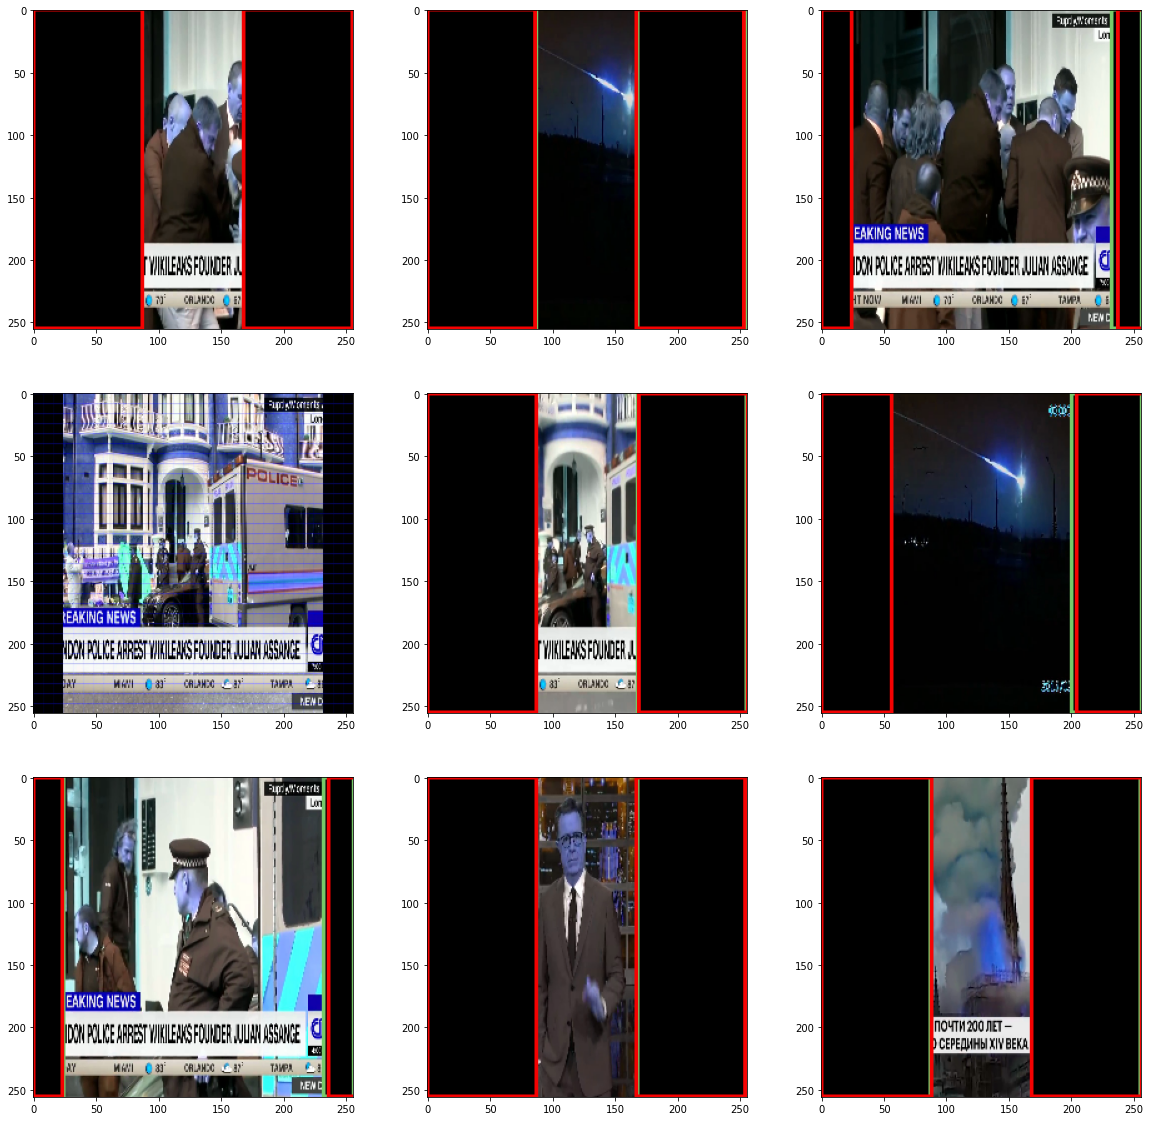

In [12]:
def test_model(model, test_datagen):
  example, label = next(test_datagen)
  x = example['image']
  box = label['box_out']

  pred_box = model.predict(x)
  pred_coords = pred_box[0]
  gt_coords = box[0]

  plt.figure(figsize=(20, 20))  
  for i, img, pred_coords, gt_coords in zip(range(len(x)), x, pred_box, box):
    image = img * 255
    image = plot_bounding_box(image, gt_coords, pred_coords)

    plt.subplot(3, 3, i + 1)
    plt.imshow(image)

  plt.show()

def test(model):
  test_datagen = data_generator(image_path, 9)
  test_model(model, test_datagen)
  
test(model)

# Визуализация функции ошибки и метрики качества


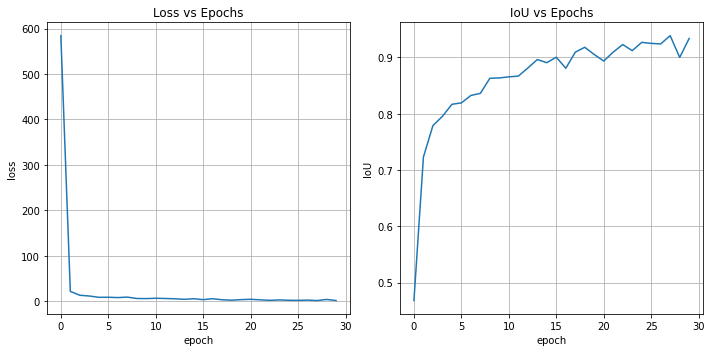

In [10]:
frame = pd.DataFrame(history.history)

fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
frame['loss'].plot(title="Loss vs Epochs",  ax=ax[0], grid= True)
frame['iou'].plot(ax=ax[1], title="IoU vs Epochs", grid= True)
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[1].set_ylabel('IoU')
ax[1].set_xlabel('epoch')
plt.tight_layout()
plt.show()